# LDED Audiovisual Fusion 

Author: Chen Lequn.
Created on 3 Oct 2023.

- Material: Maraging Steel 300
- Process: Robotic Laser-directed energy deposition
- Recorded data: position, veolocity, coaxial ccd features, audio feature
- Quality labels generated: keyhole pores, cracks, defect-free

### Notebook 2b: Audio Visual Feature Analysis
- Using the handcrafted features from video and audio stream
- Vision features: melt pool geometric features, including width, length, moment of area, convex hull, etc.
- Audio features: spectral centroid, spectral bandwidth, flux, etc.
- Feature visualization, correlation analysis
- Dimensionality reduction

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV  
from sklearn import metrics
from sklearn.metrics import classification_report

In [4]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [5]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [6]:
import sys
sys.path.insert(0, '../utils')
import glob
import os
# import utils
FRAME_SIZE = 2048
HOP_LENGTH = 512

In [18]:
def plot_data_distribution(data, variable, title, filename, figure_size = ((7,6))):
    # Initialize the plot
    plt.figure(figsize = figure_size)
    
    # Create the countplot
    ax = sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel("Categories", fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    save_fig(f"{filename}.png")
    plt.show()

In [7]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'feature_extraction')
os.makedirs(IMAGE_PATH, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz_buffered')
                            

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

## Import Extracted features

In [100]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'data_audio_visual.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name'])
df_multimodal

,sample index,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,X,Y,Z,...,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_area,contour_length
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.136620,0.265042,9.588183,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,Defective,1.0,21,0.128219,0.275541,3.966295,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,Defective,1.0,21,0.126358,0.276802,2.995122,...,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,305442.0,2234.000000
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,Defective,1.0,21,0.124890,0.278469,2.108443,...,-0.008049,0.062216,0.001940,-0.002304,-0.001599,0.000891,307.440996,230.264496,291865.5,2279.781744
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.124157,0.278818,1.804407,...,-0.009879,0.065910,0.001738,-0.003345,-0.000898,0.001388,296.636877,229.109962,281970.0,2407.847760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21156,11392,sample_23_11392.wav,sample_23_11392.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
21157,11393,sample_23_11393.wav,sample_23_11393.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
21158,11394,sample_23_11394.wav,sample_23_11394.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
21159,11395,sample_23_11395.wav,sample_23_11395.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [101]:
df_multimodal['class_name'].unique()

['Laser-off', 'Crack', 'Defect-free', 'Keyhole pores']
Categories (4, object): ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']

In [111]:
df_multimodal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18601 entries, 0 to 21160
Columns: 129 entries, sample index to contour_length
dtypes: category(4), float32(52), float64(71), int64(2)
memory usage: 16.1 MB


Saving figure dataset_distribution.png


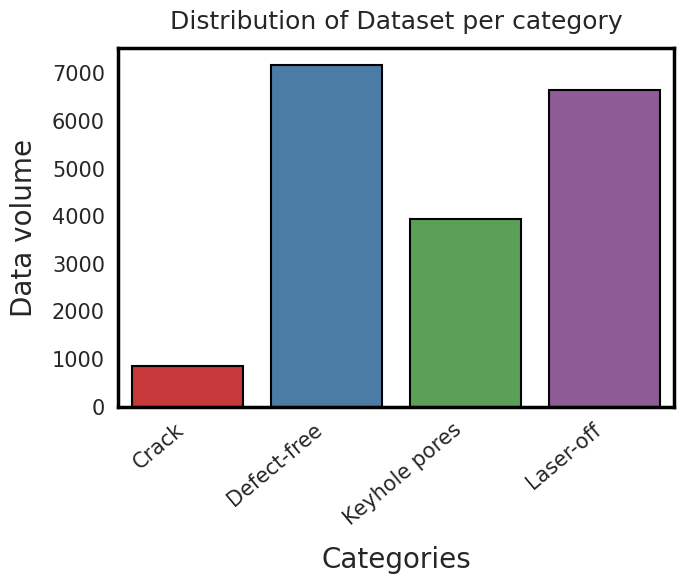

In [103]:
plot_data_distribution(df_multimodal, 'class_name', 
                       'Distribution of Dataset per category', 'dataset_distribution')

In [104]:
df_multimodal.groupby('class_name').describe()

sample index                                                    \
                     count         mean          std    min      25%     50%   
class_name                                                                     
Crack                860.0  3966.074419  2331.026980    2.0  1847.25  3882.5   
Defect-free         7164.0  2284.985483  2044.196097    1.0   777.00  1633.0   
Keyhole pores       3937.0  5224.297943  2651.525333  711.0  3632.00  4196.0   
Laser-off           6640.0  5232.578765  3300.115072    1.0  2430.75  4906.5   

                                Layer number             ... contour_area  \
                   75%      max        count       mean  ...          75%   
class_name                                               ...                
Crack          5896.25   9275.0        857.0  27.124854  ...   305112.875   
Defect-free    3006.25   7989.0       7163.0  14.675834  ...   302361.625   
Keyhole pores  4882.00  11154.0       3937.0  41.135890  ...   219318.500   
Laser-off      7593.25  11396.0       6408.0  24.977060  ...        0.000   

                        contour_length                                       \
                    max          count         mean         std         min   
class_name                                                                    
Crack          305442.0          860.0  2292.800168  192.358843  103.112698   
Defect-free    305442.0         7164.0  2361.052274  207.273110    0.000000   
Keyhole pores  305442.0         3937.0  2190.479866  289.672747    0.000000   
Laser-off      305442.0         6640.0   103.139742  339.639445    0.000000   

                                                                   
                       25%          50%          75%          max  
class_name                                                         
Crack          2234.000000  2280.666082  2382.074940  3354.081506  
Defect-free    2267.300639  2360.030043  2466.512798  3399.350618  
Keyhole pores  2064.503736  2155.862040  2253.899495  3778.362810  
Laser-off         0.000000     0.000000     0.000000  4491.850179  

[4 rows x 1000 columns]

# Data feature analysis

## 1. Intra-modality Feature Correlation Analysis: Find the top N correlated features with a given feature 
- If the given feature is from the audio set, only audio features will be considered for correlation.
- If the given feature is from the vision set, only vision features will be considered for correlation.

__Redundant Features__: If multiple features are highly correlated, they often carry the same information. Reducing these can help in preventing multicollinearity in linear models and can also reduce the dimensionality of your data, making models train faster and potentially improving generalization.

In [105]:
audio_features = [
        'rms_energy', 'amplitude_envelope_mean','amplitude_envelope_std', 'zero_crossing_rate', 'dynamic_complexity',
        'loudness', 'loudness_vickers', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_complexity_mean',
        'spectral_complexity_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean',
        'spectral_contrast_1_std', 'spectral_contrast_2_mean', 'spectral_contrast_2_std', 'spectral_contrast_3_mean',
        'spectral_contrast_3_std', 'spectral_contrast_4_mean', 'spectral_contrast_4_std', 'spectral_contrast_5_mean',
        'spectral_contrast_5_std', 'spectral_valley_0_mean', 'spectral_valley_0_std', 'spectral_valley_1_mean',
        'spectral_valley_1_std', 'spectral_valley_2_mean', 'spectral_valley_2_std', 'spectral_valley_3_mean',
        'spectral_valley_3_std', 'spectral_valley_4_mean','spectral_valley_4_std', 'spectral_valley_5_mean',
        'spectral_valley_5_std', 'spectral_decrease_mean', 'spectral_decrease_std', 'spectral_energy_mean', 'spectral_energy_std',
        'spectral_energy_band_ratio_mean', 'spectral_energy_band_ratio_std',
        'spectral_flatness_mean', 'spectral_flatness_std', 'spectral_flux_mean', 'spectral_flux_std', 'spectral_rolloff_mean', 'spectral_rolloff_std',
        'spectral_strong_peak_mean', 'spectral_strong_peak_std', 'spectral_variance_mean', 'spectral_variance_std',
        'spectral_skewness_mean', 'spectral_skewness_std','spectral_kurtosis_mean', 'spectral_kurtosis_std',
        'spectral_crest_factor_mean', 'spectral_crest_factor_std','mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean',
        'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std',
        'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean',
        'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std',
        'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std','mfcc_12_mean', 'mfcc_12_std'
    ]

vision_features = [
        'max_contour_area', 'rectangle_angle',
        'rectangle_width', 'rectangle_height', 'ellipse_angle', 'ellipse_width',
        'ellipse_height', 'max_hull', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02',
        'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02', 'mu30', 'mu21',
        'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12', 'nu03',
        'center_x', 'center_y', 'contour_area', 'contour_length'
    ]

Top 20 features correlated with max_contour_area (using spearman correlation):
Index(['max_contour_area', 'max_hull', 'm00', 'contour_area', 'mu20', 'mu02',
       'm10', 'm20', 'm30', 'm11', 'm21', 'm01', 'm12', 'm02', 'm03',
       'center_x', 'nu20', 'ellipse_height', 'rectangle_height',
       'rectangle_width'],
      dtype='object')
Saving figure intra-modality correlation_with_max_contour_area_spearman.png


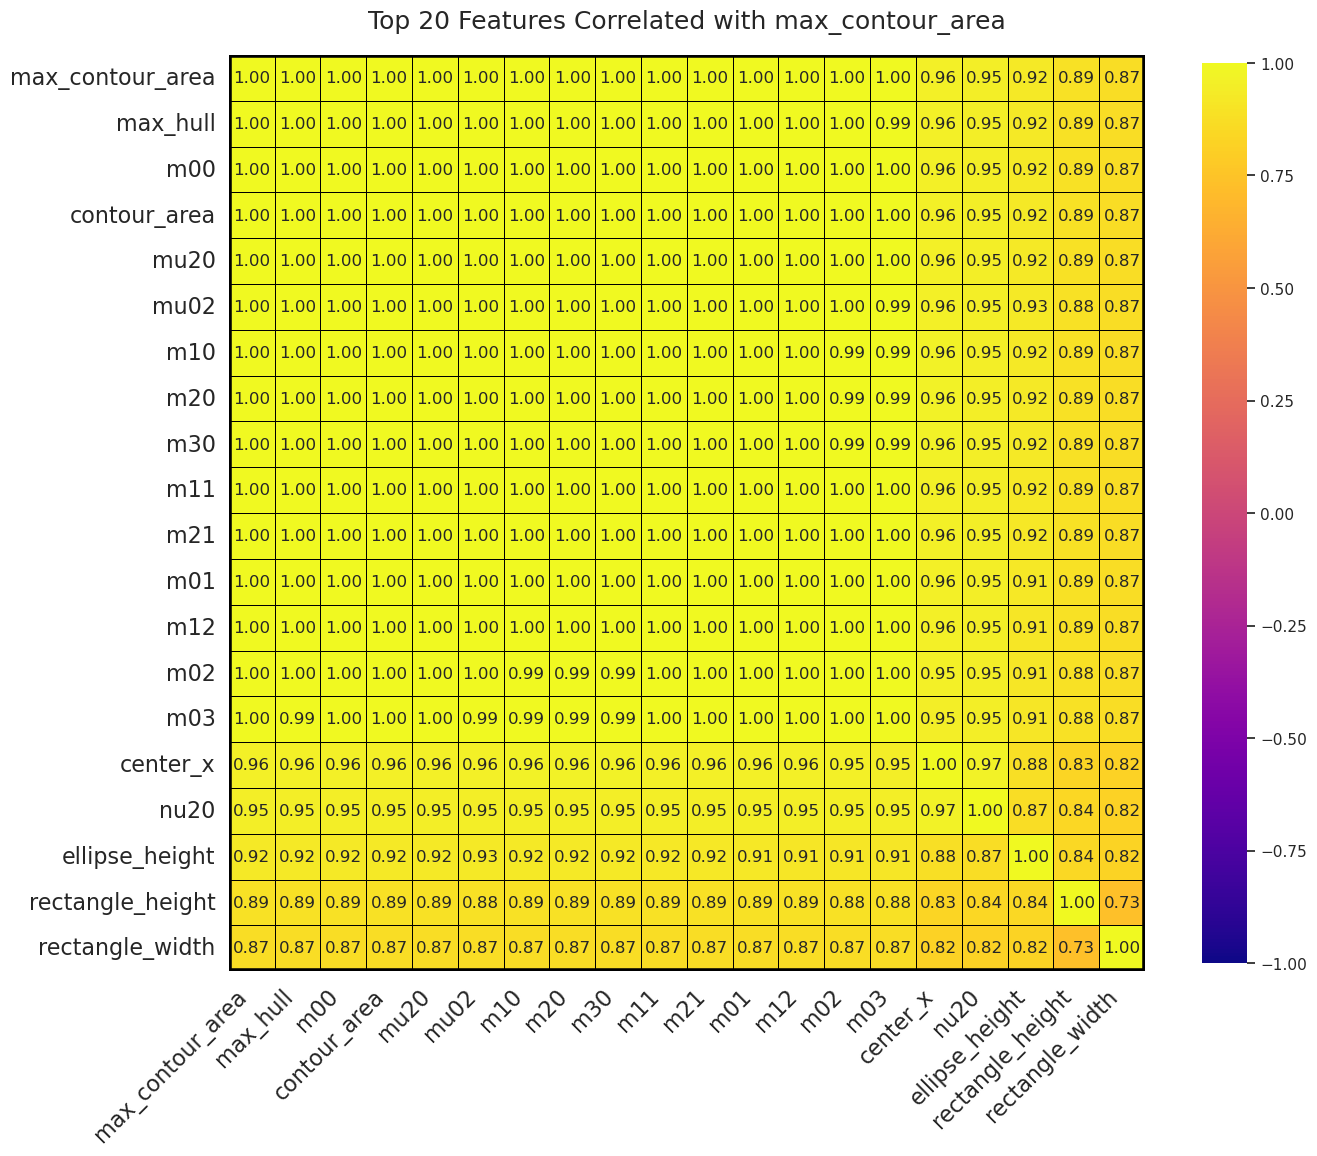

In [131]:
def plot_top_correlated_intermodality_features(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in audio_features:
        relevant_features = audio_features
    elif feature_name in vision_features:
        relevant_features = vision_features
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return

    # Compute correlations with the given feature using the specified correlation method
    correlations_with_feature = dataset[relevant_features].corr(method=method)[feature_name]
    
    # Get top N absolute correlations (including the feature_name)
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[top_correlations].corr(method=method)

    # Print the top N features
    print(f"Top {top_n} features correlated with {feature_name} (using {method} correlation):")
    print (top_correlations)


    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    save_fig(f"intra-modality correlation_with_{feature_name}_{method}.png")

# Example usage:
plot_top_correlated_intermodality_features(df_multimodal, 'max_contour_area', method='spearman', top_n=20)

### Conclusion: 
1. Higligh correlated, redundant visual features: [__'max_contour_area'__, 'max_hull', 'm00', 'contour_area', 'mu20', 'mu02', 'm10', 'm20', 'm30', 'm11', 'm21', 'm01', 'm12', 'm02', 'm03']

2. Higligh correlated, redundant audio features: [__'mfcc_0_mean'__, 'spectral_valley_3_mean', 'spectral_valley_2_mean']

3. third set [__'spectral_flux_mean'__, 'spectral_energy_mean', 'rms_energy','spectral_energy_std', 'amplitude_envelope_mean']

4. [__'nu20'__, 'center_x', 'mu20', 'm21', 'm30', 'm11', 'm00', 'contour_area', 'm01', 'm20', 'm10', 'max_contour_area', 'max_hull', 'm12', 'm02']

In [126]:
redundant_visual_feature = ['max_hull', 'm00', 'contour_area', 'mu20', 'mu02', 'm10', 'm20', 'm30', 'm11', 'm21', 'm01', 'm12', 'm02', 
                            'm03', "center_x", 'm00']
redundant_audio_feature = ['spectral_energy_mean', 'rms_energy','spectral_energy_std', 'amplitude_envelope_mean',
                           'spectral_valley_3_mean', 'spectral_valley_2_mean', 'dynamic_complexity', 'loudness']

# Remove these redundant columns from the df_multimodal DataFrame
df_multimodal_dropped = df_multimodal.drop(columns=redundant_visual_feature + redundant_audio_feature)

# Show some information about the updated DataFrame to confirm that the columns have been dropped
df_multimodal_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18601 entries, 0 to 21160
Columns: 106 entries, sample index to contour_length
dtypes: category(4), float32(49), float64(51), int64(2)
memory usage: 13.1 MB


In [110]:
df_multimodal_dropped

,sample index,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,X,Y,Z,...,nu20,nu11,nu02,nu30,nu21,nu12,nu03,center_x,center_y,contour_length
0,1,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,0.136620,0.265042,9.588183,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,sample_21_2.wav,sample_21_2.jpg,Crack,Defective,1.0,21,0.128219,0.275541,3.966295,...,0.111402,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,2234.000000
2,3,sample_21_3.wav,sample_21_3.jpg,Crack,Defective,1.0,21,0.126358,0.276802,2.995122,...,0.111402,0.000000,0.062337,0.000000,0.000000,0.000000,0.000000,319.500000,239.000000,2234.000000
3,4,sample_21_4.wav,sample_21_4.jpg,Crack,Defective,1.0,21,0.124890,0.278469,2.108443,...,0.110561,-0.008049,0.062216,0.001940,-0.002304,-0.001599,0.000891,307.440996,230.264496,2279.781744
4,5,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,0.124157,0.278818,1.804407,...,0.106234,-0.009879,0.065910,0.001738,-0.003345,-0.000898,0.001388,296.636877,229.109962,2407.847760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21156,11392,sample_23_11392.wav,sample_23_11392.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21157,11393,sample_23_11393.wav,sample_23_11393.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21158,11394,sample_23_11394.wav,sample_23_11394.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21159,11395,sample_23_11395.wav,sample_23_11395.jpg,Laser-off,Laser-off,50.0,23,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 2. Cross-modality feature analysis: Find the top N correlated features with a given feature 
- If the given feature is from the audio set, only visual features will be considered for correlation.
- If the given feature is from the vision set, only audio features will be considered for correlation.

    - This is a crucial step, especially for multimodal data. It helps to understand if there's any redundancy between the two modalities. For instance, if a visual feature is highly correlated with an audio feature, it might indicate that they both capture the same event or phenomenon.

    - A correlation of 0.5 is moderate. It suggests that there's some relationship between the audio and visual features, but it's not a perfect linear relationship. This is often a good sign because it indicates that while the two modalities have some overlap in the information they capture, they also provide unique information

Saving figure cross-modality correlation_with_max_contour_area_spearman.png


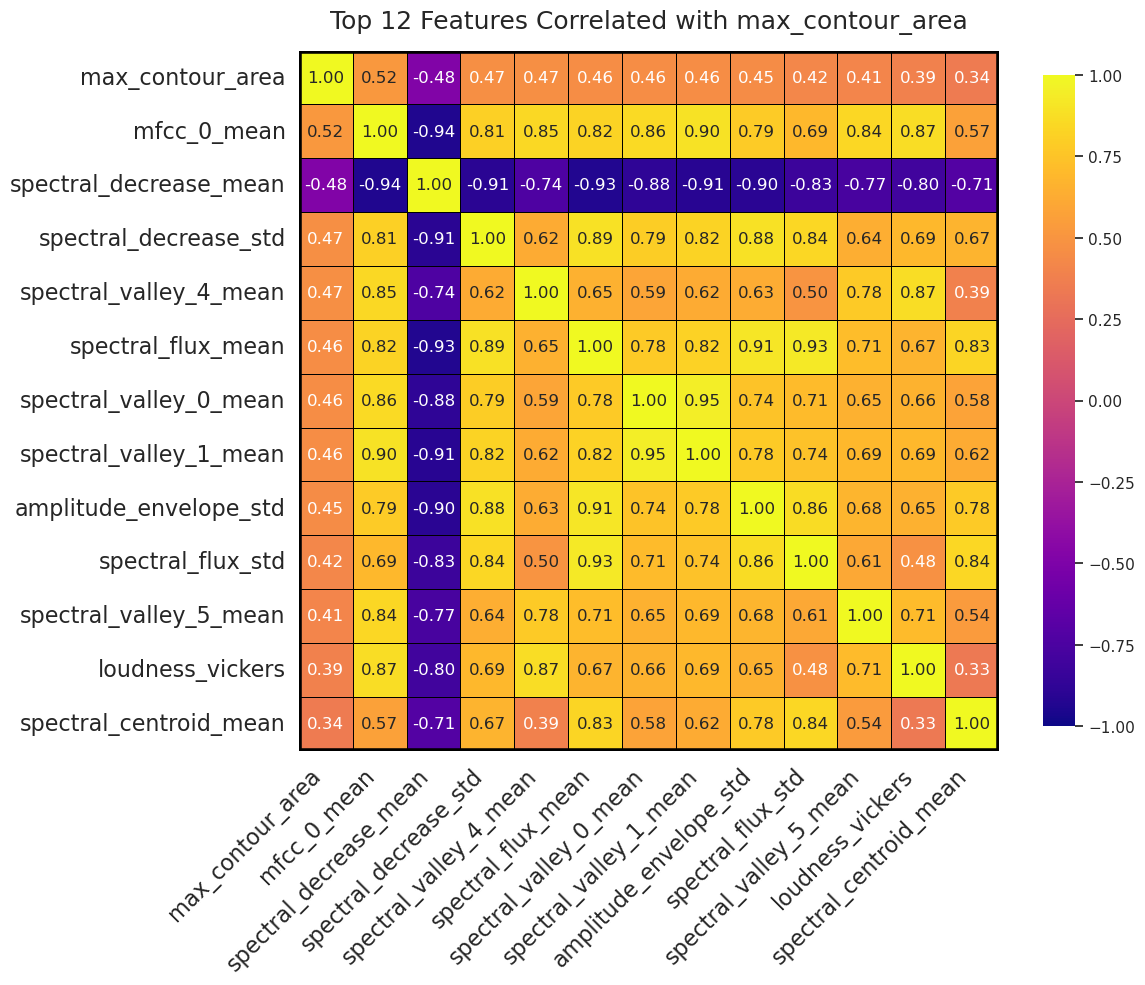

In [120]:
def plot_top_correlated_features(dataset, feature_name, method='spearman', top_n=10):
    """
    Function to plot the top N correlated features with a given feature from the dataset.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - feature_name (str): The feature with which correlations are to be found.
    - method (str): The correlation method, default is 'spearman'.
    - top_n (int): Number of top correlated features to be plotted, default is 10.
    """
    
    
    # Ensure the provided feature_name exists in the dataset
    if feature_name not in dataset.columns:
        print(f"Feature '{feature_name}' not found in the dataset!")
        return

    # Determine if the given feature is from audio or vision
    if feature_name in audio_features:
        relevant_features = list(set(vision_features) - set(redundant_visual_feature)) 
    elif feature_name in vision_features:
        relevant_features = list(set(audio_features) - set(redundant_audio_feature))
    else:
        print(f"Feature '{feature_name}' is not recognized as audio or vision feature!")
        return


    # Compute correlations with the given feature using the specified correlation method
    correlations = dataset[[feature_name] + relevant_features].corr(method=method)
    correlations_with_feature = correlations[feature_name].drop(feature_name)

    # Get top N absolute correlations
    top_correlations = correlations_with_feature.abs().nlargest(top_n).index
    top_correlation_values = dataset[[feature_name] + list(top_correlations)].corr(method=method)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    
    plt.title(f"Top {top_n} Features Correlated with {feature_name}", fontsize=18, y=1.02)
    save_fig(f"cross-modality correlation_with_{feature_name}_{method}.png")
    plt.show()

# Example usage:
plot_top_correlated_features(df_multimodal_dropped, 'max_contour_area', method='spearman', top_n=12)

### 3. Top Correlated Features for Each Individual Output Category:

- After removing redundant features
- The labels in the column `class_name` are categorical strings. Correlation with categorical strings doesn't make sense in the context of Spearman or Pearson correlation. 
- One way to handle this is to convert each class to a binary format, where 1 indicates the presence of the class and 0 indicates the absence.

By understanding which features are most indicative of each category, you can gain insights into the nature of the data and the categories themselves.
Certain phenomena might be more easily captured by one modality over another.

Saving figure correlation_matrix_Crack_spearman.png


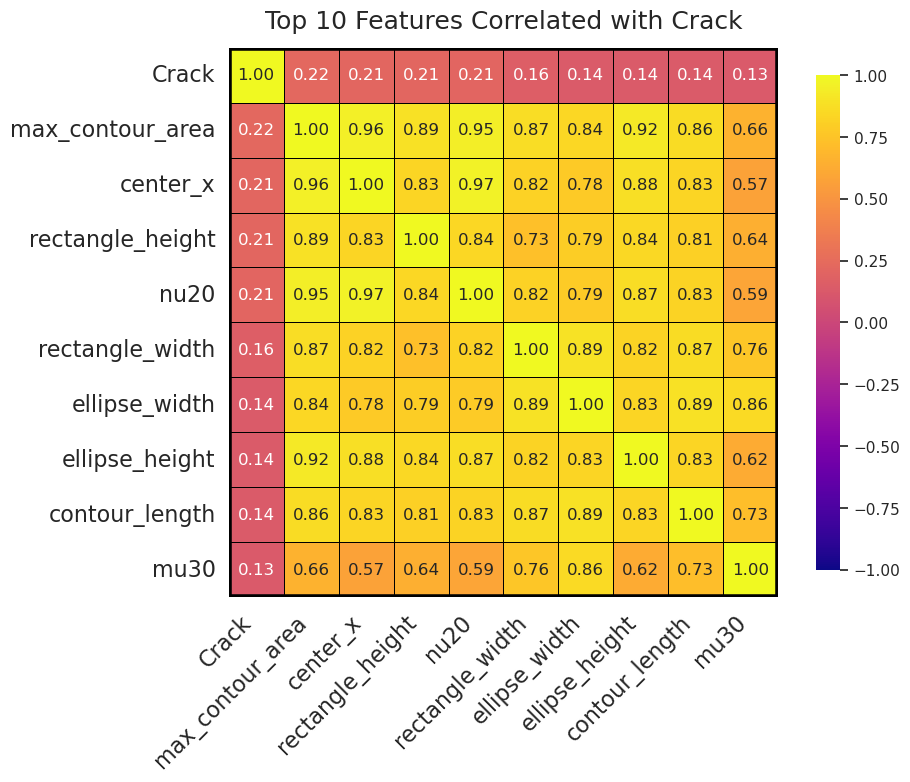

Saving figure correlation_matrix_Defect-free_spearman.png


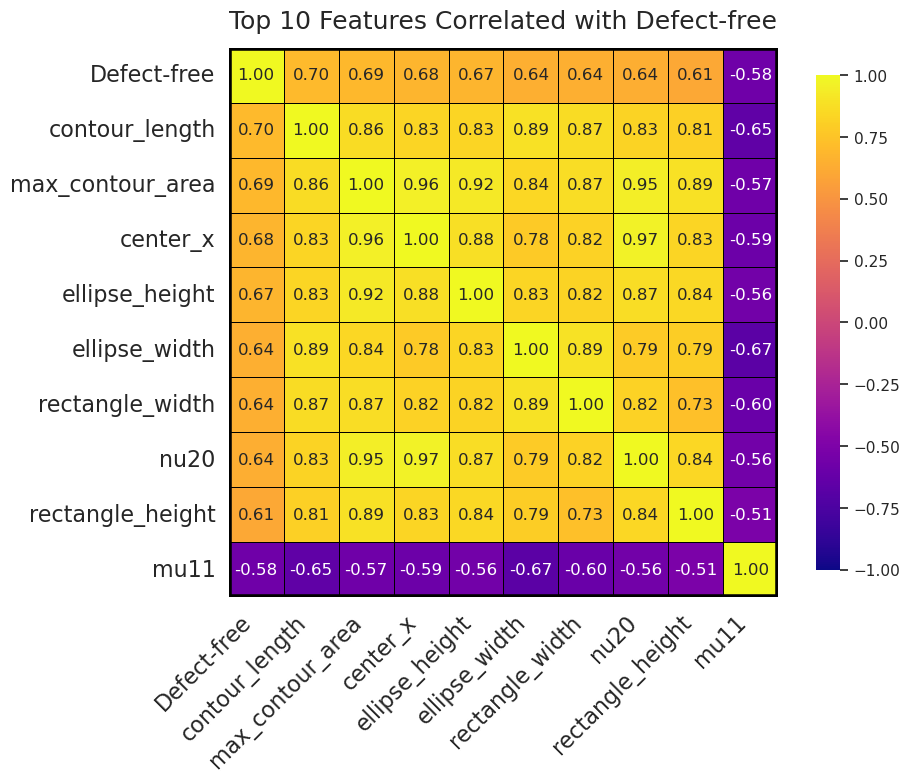

Saving figure correlation_matrix_Keyhole pores_spearman.png


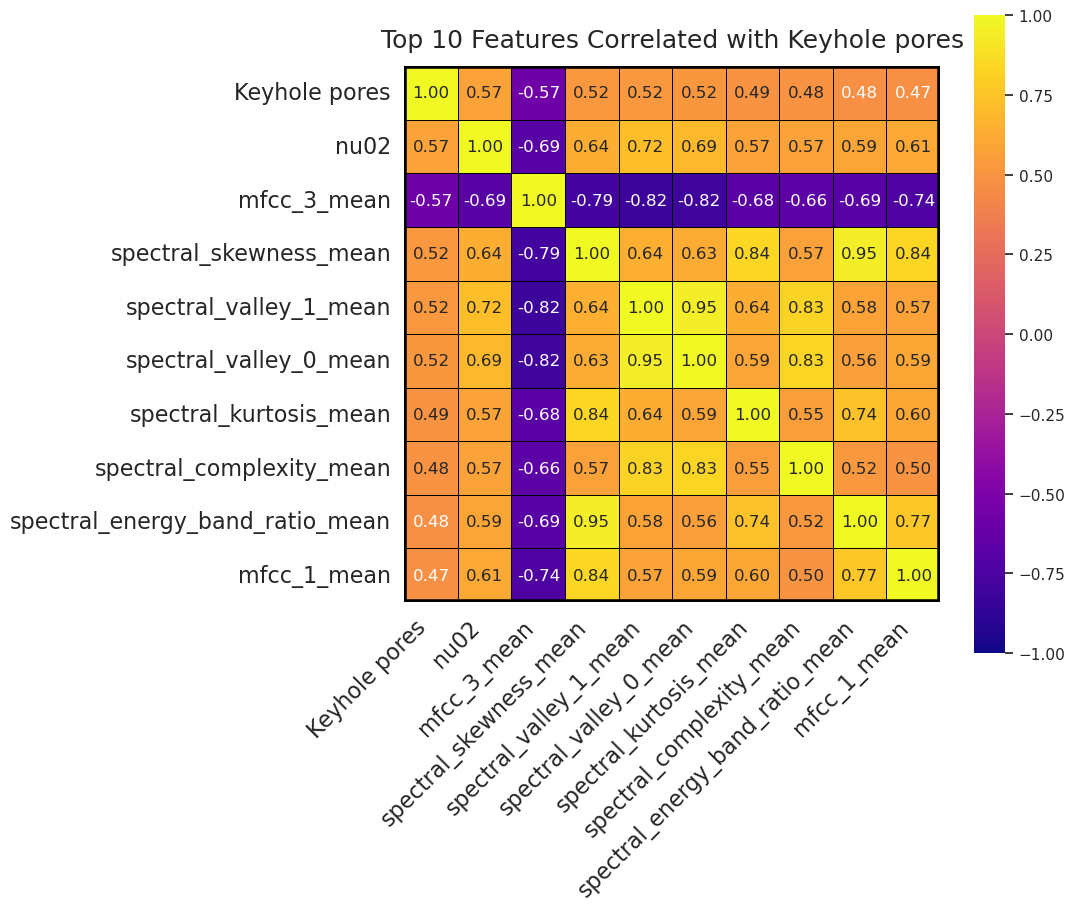

Saving figure correlation_matrix_Laser-off_spearman.png


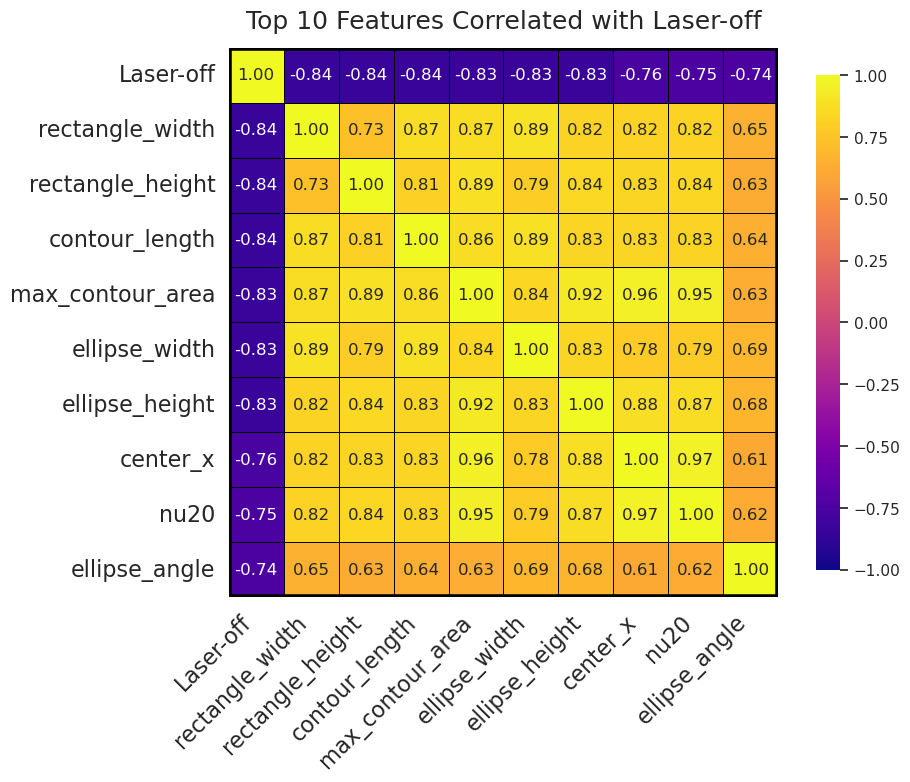

In [122]:
def plot_custom_style_top_correlated_features(dataset, target_column, method='spearman', top_n=10):
    # Convert the target_column to binary format
    dataset_binary = dataset.copy()
    dataset_binary[target_column] = pd.get_dummies(dataset_binary['class_name'])[target_column]

    # Drop non-feature columns
    non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                           'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']
    dataset_dropped = dataset_binary.drop(columns=non_feature_columns)
    
    # Compute correlations with the target column using Spearman/Pearson correlation
    correlations_with_target = dataset_dropped.corr(method=method)[target_column].drop(target_column)
    
    # Get top N absolute correlations (including the target)
    top_correlations = correlations_with_target.abs().nlargest(top_n - 1).index
    top_correlations = top_correlations.insert(0, target_column)
    top_correlation_values = dataset_dropped[top_correlations].corr(method=method)

    # Adjust figure size for 'Keyhole pores'
    fig_size = (11, 10) if target_column == 'Keyhole pores' else (10, 8)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=fig_size)
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k', linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k', linewidth=4)
    ax.axvline(x=0, color='k', linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k', linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    save_fig(f"correlation_matrix_{target_column}_{method}.png")
    plt.show()

quality_categories = ['Crack', 'Defect-free', 'Keyhole pores', 'Laser-off']

# Loop over each material category to generate the plot
for quality in quality_categories:
    plot_custom_style_top_correlated_features(df_multimodal_dropped, quality, method='spearman', top_n=10)

### 4. Correlation with Output Class

This step is about understanding the overall relationship between features and the target, regardless of the specific categories within the target. It gives a holistic view and can be particularly useful for:
1. Feature selection: If certain features are very weakly correlated with the overall target, they might not be useful predictors.
2. Understanding the general importance of features: While individual category correlations give insights about specific classes, this step gives a broader perspective.
3. Preparing for machine learning models that might treat the problem as multi-class without focusing on individual categories.

Saving figure Top 20 Features Correlated with class_name


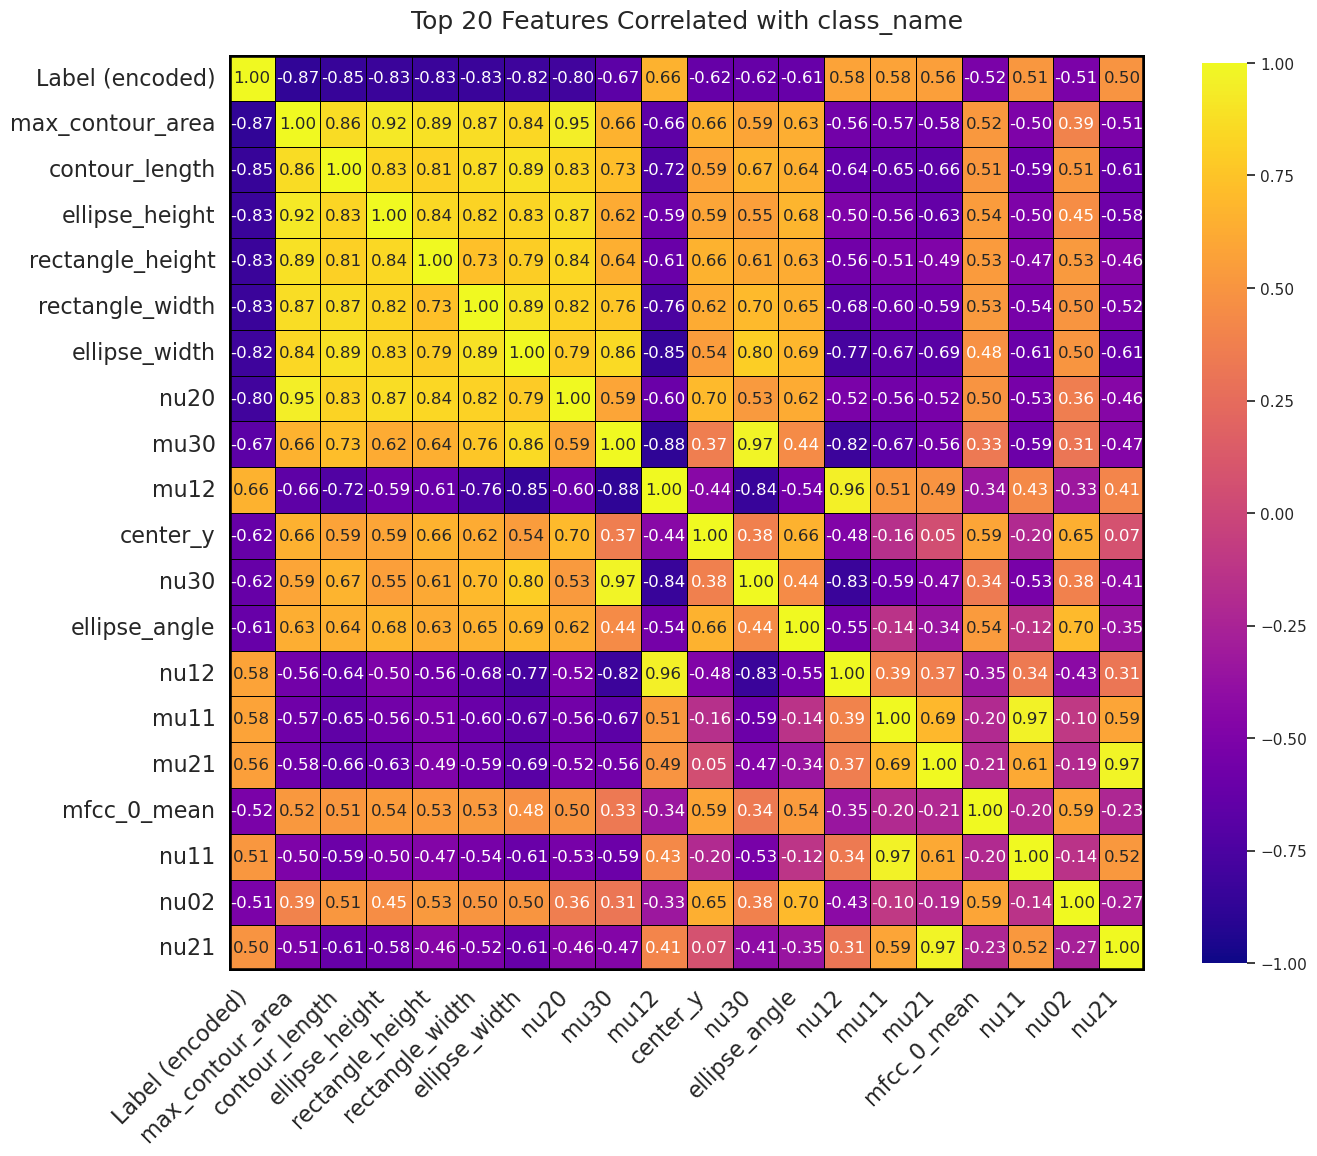

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def plot_correlation_with_output_class(dataset, target_column='class_name', method='spearman', top_n=10):
    
    # Remove non-feature columns
    non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                           'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']
    dataset_features = dataset.drop(columns=non_feature_columns)
    
    # Convert categorical class labels into numeric labels
    le = LabelEncoder()
    dataset_features['Label (encoded)'] = le.fit_transform(dataset[target_column])
    
    # Compute correlations with the target class
    correlations = dataset_features.corr(method=method)
    correlations_with_class = correlations['Label (encoded)']
    
    # Get top N absolute correlations (including the target class)
    top_correlations = correlations_with_class.abs().nlargest(top_n).index
    top_correlation_values = dataset_features[top_correlations].corr(method=method)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(
        top_correlation_values,
        vmin=-1, vmax=1, center=0,
        cmap="plasma",
        square=True,
        ax=ax,
        annot=True,
        fmt='.2f',
        cbar_kws={"shrink": .9},
        linewidths=0.5, linecolor='black'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right',
        fontsize=16
    )
    ax.set_yticklabels(
        ax.get_yticklabels(),
        rotation=0,
        fontsize=16
    )
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=top_correlation_values.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=top_correlation_values.shape[0], color='k',linewidth=4)
    plt.title(f"Top {top_n} Features Correlated with {target_column}", fontsize=18, y=1.02)
    save_fig(f"Top {top_n} Features Correlated with {target_column}")
    # plt.show()

# Usage
plot_correlation_with_output_class(df_multimodal_dropped, target_column='class_name', method='spearman', top_n=20)

### Feature importance ranking by RF

contour_length              0.089711
rectangle_height            0.070063
max_contour_area            0.066196
nu02                        0.053598
rectangle_width             0.048400
center_y                    0.047476
ellipse_height              0.047241
ellipse_width               0.041942
mfcc_3_mean                 0.036321
mu30                        0.036024
spectral_skewness_mean      0.030106
nu12                        0.030012
mu12                        0.026461
mfcc_1_mean                 0.022281
spectral_valley_1_mean      0.022094
nu20                        0.020573
ellipse_angle               0.019084
spectral_valley_0_mean      0.018907
mu21                        0.018701
nu21                        0.017586
mu03                        0.014412
mu11                        0.014037
nu11                        0.011862
spectral_contrast_3_mean    0.009505
nu03                        0.008611
nu30                        0.008157
spectral_kurtosis_mean      0.007630
s

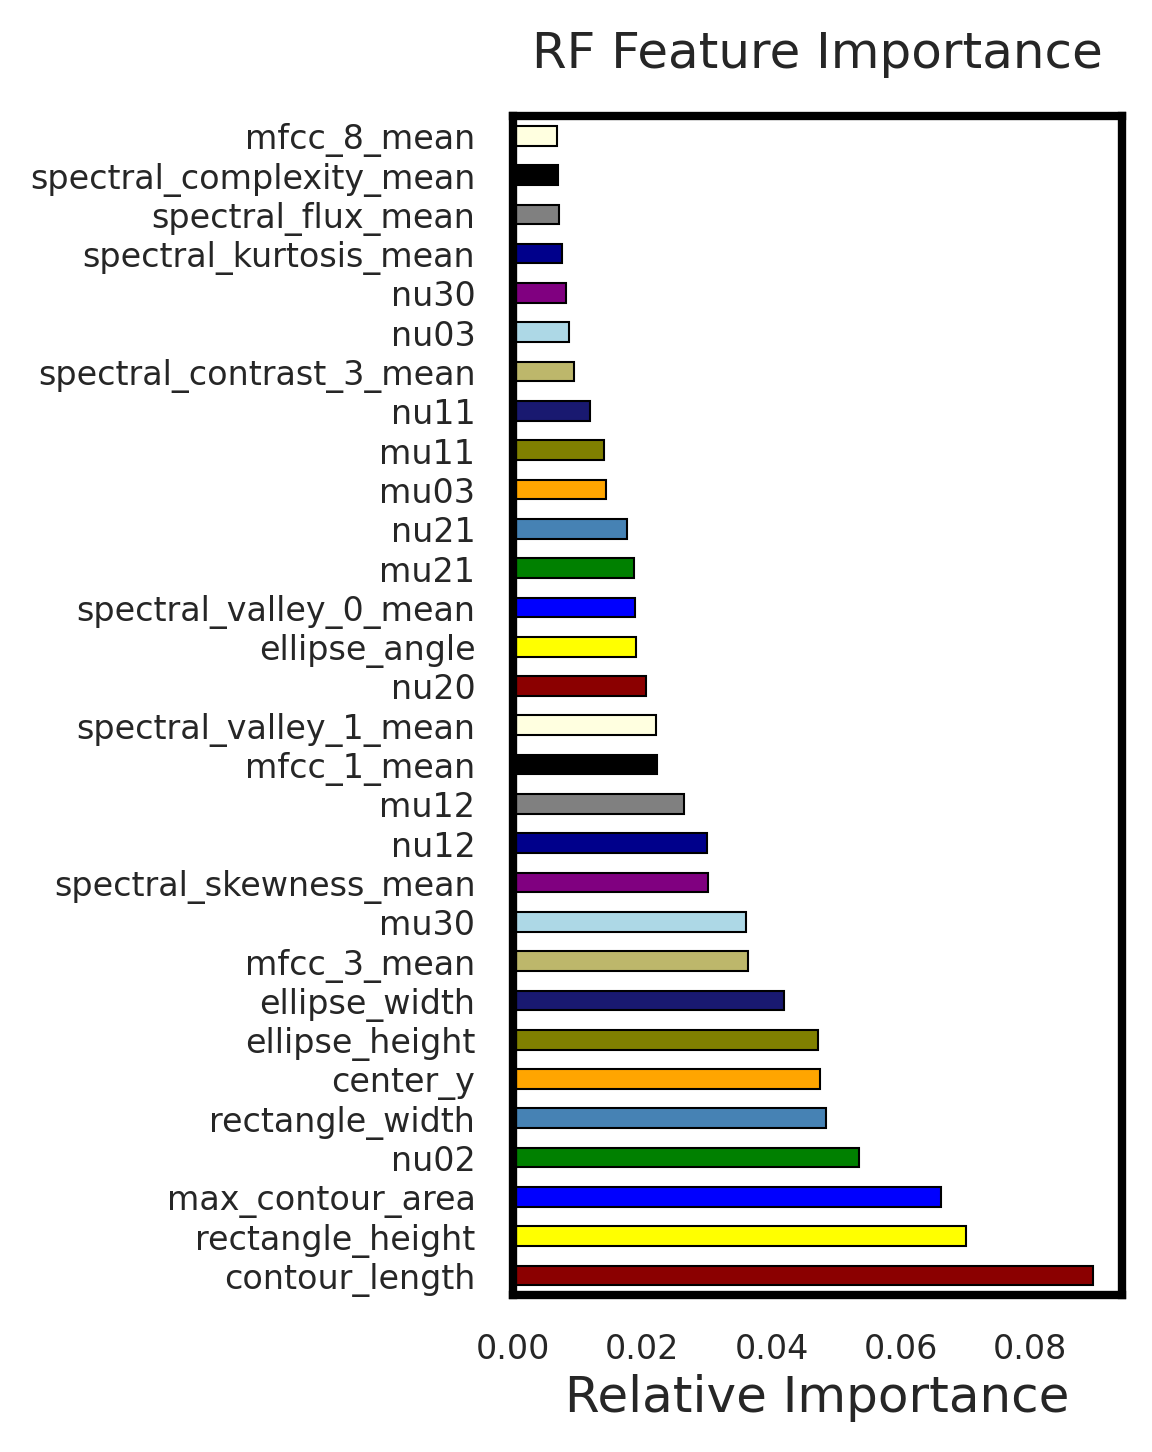

In [142]:
# Define the dataset and target variable
y = df_multimodal['class_name']

non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                           'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']
dataset_dropped = df_multimodal_dropped.drop(columns=non_feature_columns)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)
model.fit(dataset_dropped, y)

# Extract feature importances
feat_importances = pd.Series(model.feature_importances_, index=dataset_dropped.columns)


# Plotting the feature importances
fig = plt.figure(figsize=(4,5), dpi=300)
ax = plt.gca()
widths = 2
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(widths)
    
color = ['darkred','yellow', 'blue','green', 'steelblue','orange', 'olive', 'midnightblue', 'darkkhaki', 
         "lightblue", "purple", "darkblue", "gray", "black", "lightyellow"]

feat_importances.nlargest(30).plot(kind='barh', color=color, edgecolor='k', linewidth=0.5)
plt.title("RF Feature Importance", fontsize=12, y=1.02)
plt.xlabel('Relative Importance', fontsize=12, labelpad=2)
plt.tick_params(axis='both', labelsize=8, pad=3)

# Displaying the top 15 feature importances
top_feature_importances = feat_importances.nlargest(30)
print (top_feature_importances)
save_fig("RF feature importance ranking (30)")

### 5. ANOVA (Analysis of Variance) analysis

Explanation of F-value and P-value in ANOVA

- `F-value`: In the context of ANOVA (Analysis of Variance), the F-value represents the ratio of the variance between different groups to the variance within the groups. A higher F-value suggests that the feature is important in distinguishing between the different classes in the target variable.

- `Null Hypothesis in ANOVA`: The null hypothesis in ANOVA is that all classes of the target variable have the same mean for the feature being tested. In other words, the feature doesn't help in distinguishing between different classes.

- `P-value`: It's a measure to support or refute this null hypothesis. The P-value tells you the probability of observing your data, or something more extreme, if the null hypothesis is true.
    - The P-value gives the probability of obtaining an F-value at least as extreme as the one computed, assuming that the null hypothesis is true (i.e., that there's no effect or difference). A lower P-value (< 0.05 is often considered) indicates that you can reject the null hypothesis, making the feature important.

    - `Low P-value` (typically < 0.05): It means that it's very unlikely to observe such data if the null hypothesis is true. This gives you enough evidence to "reject the null hypothesis" and conclude that the feature is significant in distinguishing between different classes.

    - `High P-value`: It means that what you've observed is likely under the null hypothesis, so you don't have enough evidence to reject it. This would mean that the feature is not very useful in distinguishing between different classes.
    
- For  feature importance, the bar plot represents the top N features sorted by their F-values in the first graph and by their Mutual Information scores in the second graph.  The features at the top are considered to be more important in predicting the target variable.

In [181]:
# Importing required libraries
from sklearn.feature_selection import f_classif, mutual_info_classif
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def anova_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the ANOVA F-values and P-values for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): Sorted DataFrame containing F-values and P-values.
    """
    # Compute ANOVA F-values and P-values
    f_values, p_values = f_classif(X, y)
    
    # Create DataFrame for ANOVA feature importance
    anova_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'F_value': f_values,
        'p_value': p_values
    })

    # Sort the features by F_value in descending order
    sorted_df = anova_importance_df.sort_values(by='F_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting F-values
    plt.figure(figsize=(12, 10))
    plt.barh(top_features['Feature'], top_features['F_value'], color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('F-value', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f'Top {top_n} Features using ANOVA F-value', pad=15, fontsize=20)
    save_fig(f'Top {top_n} Features using ANOVA F-value')
    # plt.show()
    
    # Plotting P-values
    # plt.figure(figsize=(12, 10))
    # plt.barh(top_features['Feature'], top_features['p_value'], color='orange', edgecolor='black', linewidth=0.5)
    # plt.xlabel('P-value', fontsize=18, labelpad=15)
    # plt.ylabel('Feature', fontsize=18, labelpad=15)
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)
    # plt.title(f'Top {top_n} Features using ANOVA P-value', pad=15, fontsize=20)
    # plt.show()
    
    return sorted_df

Saving figure Top 25 Features using ANOVA F-value


,Feature,F_value,p_value
95,contour_length,89297.259567,0.000000e+00
77,rectangle_width,79637.992427,0.000000e+00
78,rectangle_height,77874.536434,0.000000e+00
75,max_contour_area,64446.745068,0.000000e+00
80,ellipse_width,56516.060227,0.000000e+00
...,...,...,...
24,spectral_valley_3_std,14.735185,1.399480e-09
20,spectral_valley_0_std,13.304782,1.133840e-08
23,spectral_valley_2_std,11.087401,2.875497e-07
11,spectral_contrast_2_mean,9.896349,1.622205e-06


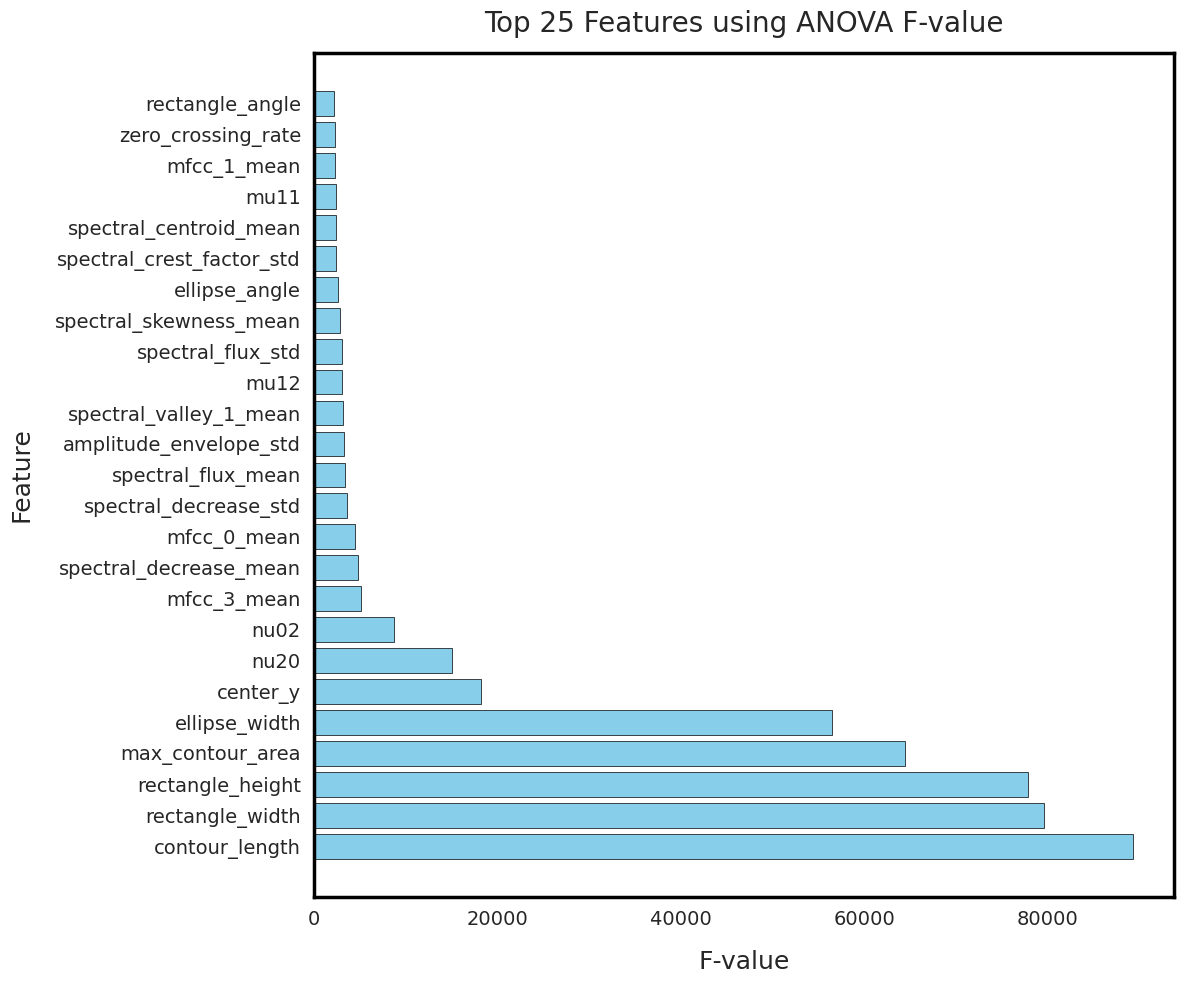

In [182]:
# Prepare data
non_feature_columns = ['sample index', 'audio_file_name', 'image_file_name', 'class_name',
                       'class_name_v2', 'Layer number', 'Sample number', 'X', 'Y', 'Z']

dataset = df_multimodal_dropped.drop(columns=non_feature_columns)
X = dataset.to_numpy()
y = df_multimodal['class_name'].to_numpy()


# Run the function 
sorted_df = anova_feature_importance(dataset, X, y, top_n=25)
sorted_df

### Feature selection based on ANOVA
- A higher F-value generally suggests that the feature is __more important or discriminative__ for classification. It indicates that the means of the different classes are more separated, which usually implies the feature is good for classification.

- A lower p-value means that the feature is __statistically significant__ in explaining the dependent variable. A  p-value less than a threshold (commonly 0.05) is typically considered evidence that the feature is important.

- However, a higher F-value does not necessarily mean a lower p-value, although they are often inversely related in many cases. The p-value is calculated based on the  F-value and the degrees of freedom in the model. It's possible for a feature to have a high  F-value but still not be statistically significant if, for example, the degrees of freedom are low.

In [186]:
def filter_anova_features(sorted_df, p_value_threshold=0.05, f_value_threshold=None):
    """
    Filter features based on ANOVA F-value and p-value.
    
    Args:
    - sorted_df (pd.DataFrame): The input DataFrame containing 'Feature', 'F_value', and 'p_value' columns.
    - p_value_threshold (float): The p-value threshold for feature elimination. Default is 0.05.
    - f_value_threshold (float): The F-value threshold for feature elimination. If None, it won't be used.
    
    Returns:
    - significant_features (list): List of significant features based on p_value and F_value.
    - insignificant_features (list): List of insignificant features based on p_value.
    """
    # Filter features based on p-value
    significant_df = sorted_df[sorted_df['p_value'] <= p_value_threshold]
    
    # Filter features based on F-value if specified
    if f_value_threshold is not None:
        significant_df = significant_df[significant_df['F_value'] >= f_value_threshold]
    
    # Get the list of significant and insignificant features
    significant_features = significant_df['Feature'].tolist()
    insignificant_features = sorted_df.loc[~sorted_df['Feature'].isin(significant_features), 'Feature'].tolist()
    
    return significant_features, insignificant_features


significant_features, insignificant_features = filter_anova_features(sorted_df, p_value_threshold=0.0001)
print("Significant features:", significant_features)
print("Insignificant features:", insignificant_features)

Significant features: ['contour_length', 'rectangle_width', 'rectangle_height', 'max_contour_area', 'ellipse_width', 'center_y', 'nu20', 'nu02', 'mfcc_3_mean', 'spectral_decrease_mean', 'mfcc_0_mean', 'spectral_decrease_std', 'spectral_flux_mean', 'amplitude_envelope_std', 'spectral_valley_1_mean', 'mu12', 'spectral_flux_std', 'spectral_skewness_mean', 'ellipse_angle', 'spectral_crest_factor_std', 'spectral_centroid_mean', 'mu11', 'mfcc_1_mean', 'zero_crossing_rate', 'rectangle_angle', 'spectral_rolloff_mean', 'mu21', 'spectral_crest_factor_mean', 'spectral_contrast_3_mean', 'spectral_complexity_mean', 'mu30', 'ellipse_height', 'mfcc_4_std', 'spectral_centroid_std', 'loudness_vickers', 'spectral_valley_5_mean', 'spectral_contrast_5_mean', 'spectral_energy_band_ratio_mean', 'spectral_valley_0_mean', 'spectral_energy_band_ratio_std', 'spectral_complexity_std', 'spectral_contrast_1_mean', 'mfcc_2_mean', 'spectral_rolloff_std', 'mu03', 'mfcc_7_mean', 'spectral_variance_std', 'mfcc_5_std', 

### 6. Mutual Informaion analysis

- Principle and Idea:

`Mutual Information (MI)` is a measure of the amount of information that one random variable contains about another. It is used in feature selection to evaluate how much information a feature (independent variable) provides about the target (dependent variable).

- How it works:

    - `Zero MI`: If the MI between a feature and the target is zero, then the feature is statistically independent of the target, i.e., it gives no information about the target.
    - `High MI`: A higher MI value suggests that knowing the value of the feature would give more information about the outcome of the target variable.

- How it is used for Feature Importance:
    - Ranking Features: After calculating MI for all features, you can rank them based on their MI values. Higher MI values suggest more important features.

- Feature Selection: You can set a threshold on the MI value to select features. Features with MI values above this threshold are usually selected.

- How it is different from ANOVA or other methods:
    - MI is a non-parametric method, meaning it doesn't assume any specific distribution for the data.
    - It can capture any kind of relationship (linear or nonlinear) between the feature and the target.

In [191]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

def mutual_info_feature_importance(dataset, X, y, top_n=10):
    """
    Compute and plot the Mutual Information for feature importance.
    
    Args:
    - dataset (pd.DataFrame): The input dataset.
    - X (array): Feature matrix.
    - y (array): Target array.
    - top_n (int): Number of top features to display.
    
    Returns:
    - sorted_df (pd.DataFrame): DataFrame containing features and their Mutual Information values, sorted.
    """
    
    # Compute Mutual Information
    mi_values = mutual_info_classif(X, y)
    
    # Create a DataFrame to hold feature names and their corresponding Mutual Information values
    feature_importances = pd.DataFrame({'feature': dataset.columns, 'mi_value': mi_values})
    
    # Sort the features by their Mutual Information values in descending order
    sorted_df = feature_importances.sort_values('mi_value', ascending=False)
    
    # Get the top N features
    top_features = sorted_df.head(top_n)
    
    # Plotting
    plt.figure(figsize=(12, 10))
    bars = plt.barh(top_features['feature'], top_features['mi_value'], color='orange', edgecolor='black', linewidth=0.5)
    plt.xlabel('Mutual Information', fontsize=18, labelpad=15)
    plt.ylabel('Feature', fontsize=18, labelpad=15)
    plt.title(f'Top {top_n} Features using Mutual Information', pad=15, fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    return sorted_df

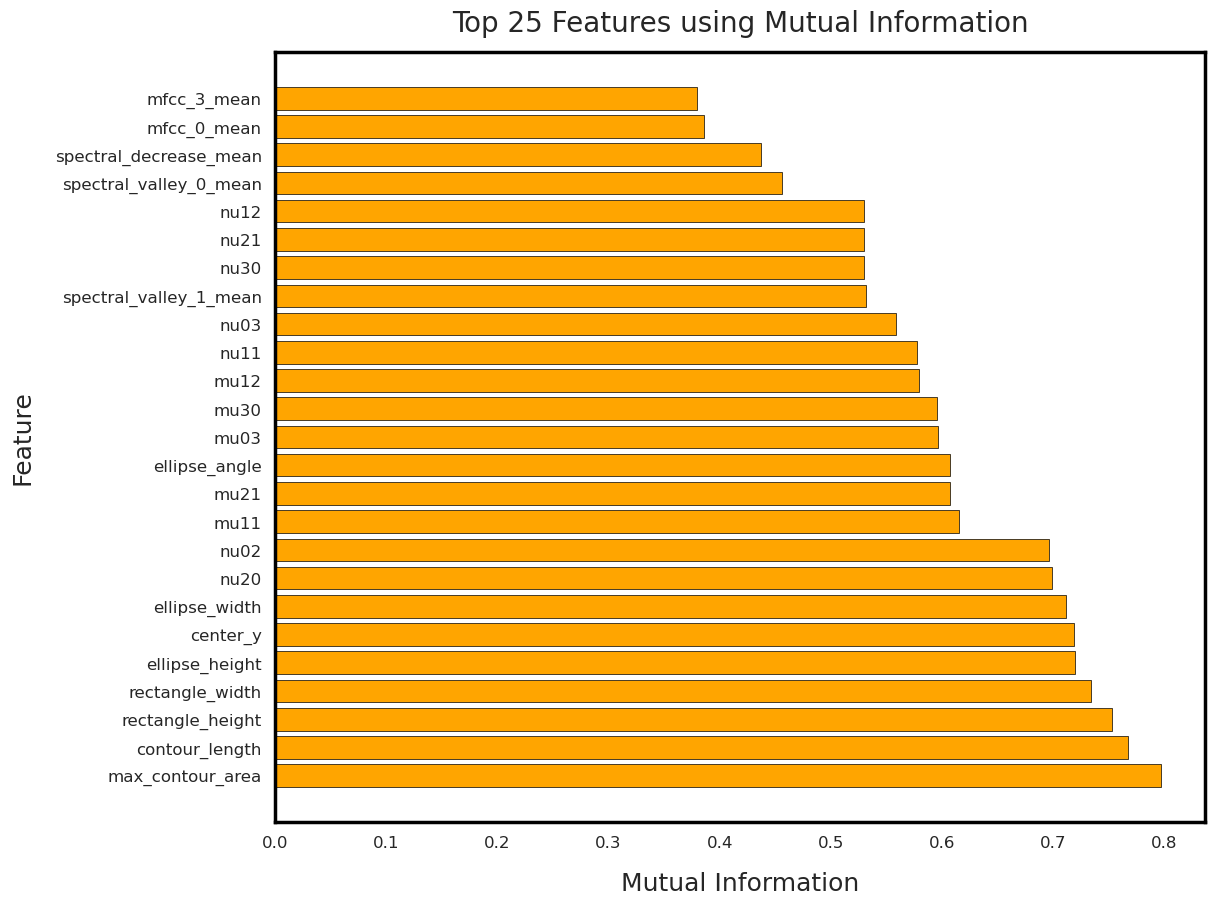

,feature,mi_value
75,max_contour_area,0.797061
95,contour_length,0.767685
78,rectangle_height,0.752831
77,rectangle_width,0.734488
81,ellipse_height,0.719900
...,...,...
64,mfcc_7_std,0.104948
66,mfcc_8_std,0.103638
72,mfcc_11_std,0.102648
70,mfcc_10_std,0.100118


In [192]:
sorted_df = mutual_info_feature_importance(dataset, X, y, top_n=25)
sorted_df